In [2]:
import os
import time
#import uuid
import cv2

In [3]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
os.chdir("/home")
os.mkdir("data")

os.chdir("/home/data")
os.mkdir("train")
os.chdir("/home/data/train")
os.mkdir("images")
os.mkdir("labels")

os.chdir("//home/data")
os.mkdir("test")
os.chdir("/home/data/test")
os.mkdir("images")
os.mkdir("labels")

os.chdir("/home/data")
os.mkdir("val")
os.chdir("/home/data/val")
os.mkdir("images")
os.mkdir("labels")

In [6]:
data="/content/drive/MyDrive/facedata/data"
data01="/home/data"

In [9]:

import albumentations as alb
augmentor = alb.Compose([alb.RandomCrop(width=160, height=200),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                       bbox_params=alb.BboxParams(format='albumentations',
                                                  label_fields=['class_labels']))
partition ="val"
jj=0
for image in os.listdir(os.path.join(data, 'images')):
  img = cv2.imread(os.path.join(data, 'images', image))

  coords = [0,0,0.00001,0.00001]
  label_path = os.path.join(data, 'labels', f'{image.split(".")[0]}.json')
  if os.path.exists(label_path):
      with open(label_path, 'r') as f:
          label = json.load(f)

      coords[0] = label['shapes'][0]['points'][0][0]
      coords[1] = label['shapes'][0]['points'][0][1]
      coords[2] = label['shapes'][0]['points'][1][0]
      coords[3] = label['shapes'][0]['points'][1][1]
      coords = list(np.divide(coords, [178,218,178,218]))

  try:
      for x in range(2):
          augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

          cv2.imwrite(os.path.join(data01, partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

          annotation = {}
          annotation['image'] = image

          if os.path.exists(label_path):
              if len(augmented['bboxes']) == 0:
                  annotation['bbox'] = [0,0,0,0]
                  annotation['class'] = 0
              else:
                  annotation['bbox'] = augmented['bboxes'][0]
                  annotation['class'] = 1
          else:
              annotation['bbox'] = [0,0,0,0]
              annotation['class'] = 0


          with open(os.path.join(data01, partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
              json.dump(annotation, f)
          jj=0
  except Exception as e:
      print(" there is a big problem  : ---->>>>> ",e)

In [10]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [11]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [12]:
train_images = tf.data.Dataset.list_files(os.path.join(data01,'train//images/*.jpg'), shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [13]:
test_images = tf.data.Dataset.list_files(os.path.join(data01,'test//images/*.jpg'), shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [14]:
val_images = tf.data.Dataset.list_files(os.path.join(data01,'val//images/*.jpg'), shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [15]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    return [label['class']], label['bbox']


In [16]:
train_labels = tf.data.Dataset.list_files(os.path.join(data01,'train//labels/*.json'), shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [17]:
test_labels = tf.data.Dataset.list_files(os.path.join(data01,'test//labels/*.json'), shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [18]:
val_labels = tf.data.Dataset.list_files(os.path.join(data01,'val//labels/*.json'), shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))


In [19]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)


In [20]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [21]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [22]:
from tensorflow.keras.models import Model ,load_model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16


### 8.2 Download VGG16

In [23]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [24]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [25]:
def build_model():
    input_layer = Input(shape=(120,120,3))

    vgg = VGG16(include_top=False)(input_layer)
    f1 = GlobalMaxPooling2D()(vgg)
    # Classification Model

    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # Bounding box model
    regress1 = Dense(2048, activation='relu')(f1)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])

    return facetracker

In [26]:
facetracker = build_model()

In [27]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [28]:
X, y = train.as_numpy_iterator().next()

In [29]:
print(y[1])

[[0.256   0.0911  0.7583  0.7    ]
 [0.1213  0.2278  0.816   0.8794 ]
 [0.1963  0.2178  0.8906  0.8696 ]
 [0.2164  0.11926 0.957   0.71   ]
 [0.1361  0.1802  0.78    0.8486 ]
 [0.3433  0.18    0.982   0.8096 ]
 [0.1377  0.0498  0.8784  0.7793 ]
 [0.1741  0.1458  0.781   0.8066 ]]


In [30]:
X.shape

(8, 120, 120, 3)

In [31]:
#from tensorflow.keras.models import load_model
#facetracker = load_model('/content/drive/MyDrive/facedata/model/facetracker03.h5')

In [32]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 8s 8s/step


In [33]:
classes, coords

(array([[0.5873548 ],
        [0.49502194],
        [0.5035818 ],
        [0.5808932 ],
        [0.5678187 ],
        [0.5464971 ],
        [0.51866066],
        [0.5404345 ]], dtype=float32),
 array([[0.4215417 , 0.5042215 , 0.38806924, 0.450871  ],
        [0.5711697 , 0.4617089 , 0.39176306, 0.5699597 ],
        [0.57335955, 0.4091051 , 0.40359333, 0.6119184 ],
        [0.5726395 , 0.41670033, 0.32068843, 0.51394504],
        [0.5609926 , 0.50148475, 0.4388446 , 0.67269343],
        [0.48978084, 0.41302294, 0.3468875 , 0.5483579 ],
        [0.5048297 , 0.37356773, 0.29811454, 0.50403446],
        [0.5816498 , 0.440158  , 0.363589  , 0.48029038]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [34]:
import tensorflow as tf

# Define a TensorFlow tensor
my_tensor = tf.constant([1, 2, 3, 4], dtype=tf.uint8)

# Print the content of the tensor
tf.print("My Tensor:", my_tensor)

My Tensor: [1 2 3 4]


In [35]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [36]:

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)


In [37]:
def localization_loss(y_true, yhat):

    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]
    print("yhat",h_pred)

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [38]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [39]:
class FaceTracker(Model):
    def __init__(self, eyetracker,  **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt



    def my_function(input_tensor):
        result = tf.square(input_tensor)  # Example operation
        return result


    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            total_loss = batch_localizationloss+0.5*batch_classloss
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [40]:
model = FaceTracker(facetracker)

In [41]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [42]:
logdir='logs'

In [43]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [44]:
hist = model.fit(train, epochs=30, callbacks=[tensorboard_callback])

#facetracker.save('/content/drive/MyDrive/facedata/model/facetracker04.h5')

Epoch 1/30
yhat Tensor("sub_3:0", shape=(None,), dtype=float32)
yhat Tensor("sub_3:0", shape=(None,), dtype=float32)
125/125 [==============================] - 21s 66ms/step - total_loss: 0.2814 - class_loss: 0.0115 - regress_loss: 0.2757
Epoch 2/30
125/125 [==============================] - 11s 59ms/step - total_loss: 0.0920 - class_loss: 1.6714e-04 - regress_loss: 0.0919
Epoch 3/30
125/125 [==============================] - 8s 56ms/step - total_loss: 0.0536 - class_loss: 9.1855e-05 - regress_loss: 0.0536
Epoch 4/30
125/125 [==============================] - 8s 55ms/step - total_loss: 0.0381 - class_loss: 2.5261e-05 - regress_loss: 0.0381
Epoch 5/30
125/125 [==============================] - 9s 57ms/step - total_loss: 0.0235 - class_loss: 1.7832e-05 - regress_loss: 0.0235
Epoch 6/30
125/125 [==============================] - 8s 58ms/step - total_loss: 0.0155 - class_loss: 9.6818e-06 - regress_loss: 0.0155
Epoch 7/30
125/125 [==============================] - 8s 57ms/step - total_loss:

### 10.3 Plot Performance

KeyError: ignored

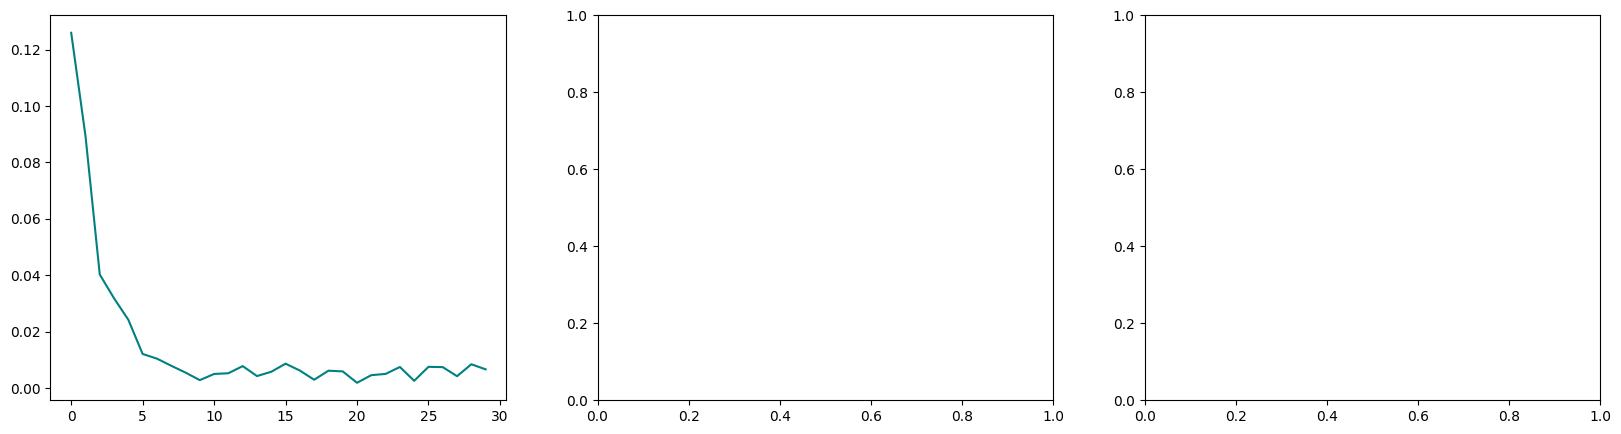

In [47]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

In [48]:
from tensorflow.keras.models import load_model



### 11.1 Make Predictions on Test Set

In [56]:
test_data = train.as_numpy_iterator()

In [64]:
test_sample = test_data.next()


In [72]:
tt=test_sample[0]
print(type(tt))

<class 'numpy.ndarray'>


In [76]:
yhat = facetracker.predict(np.array([tt[0]]))


1/1 [==============================] - 1s 540ms/step


In [77]:
print(yhat)


[array([[0.9999999]], dtype=float32), array([[0.17539443, 0.29741868, 0.7534605 , 0.9282734 ]], dtype=float32)]


(21, 35) (90, 111)


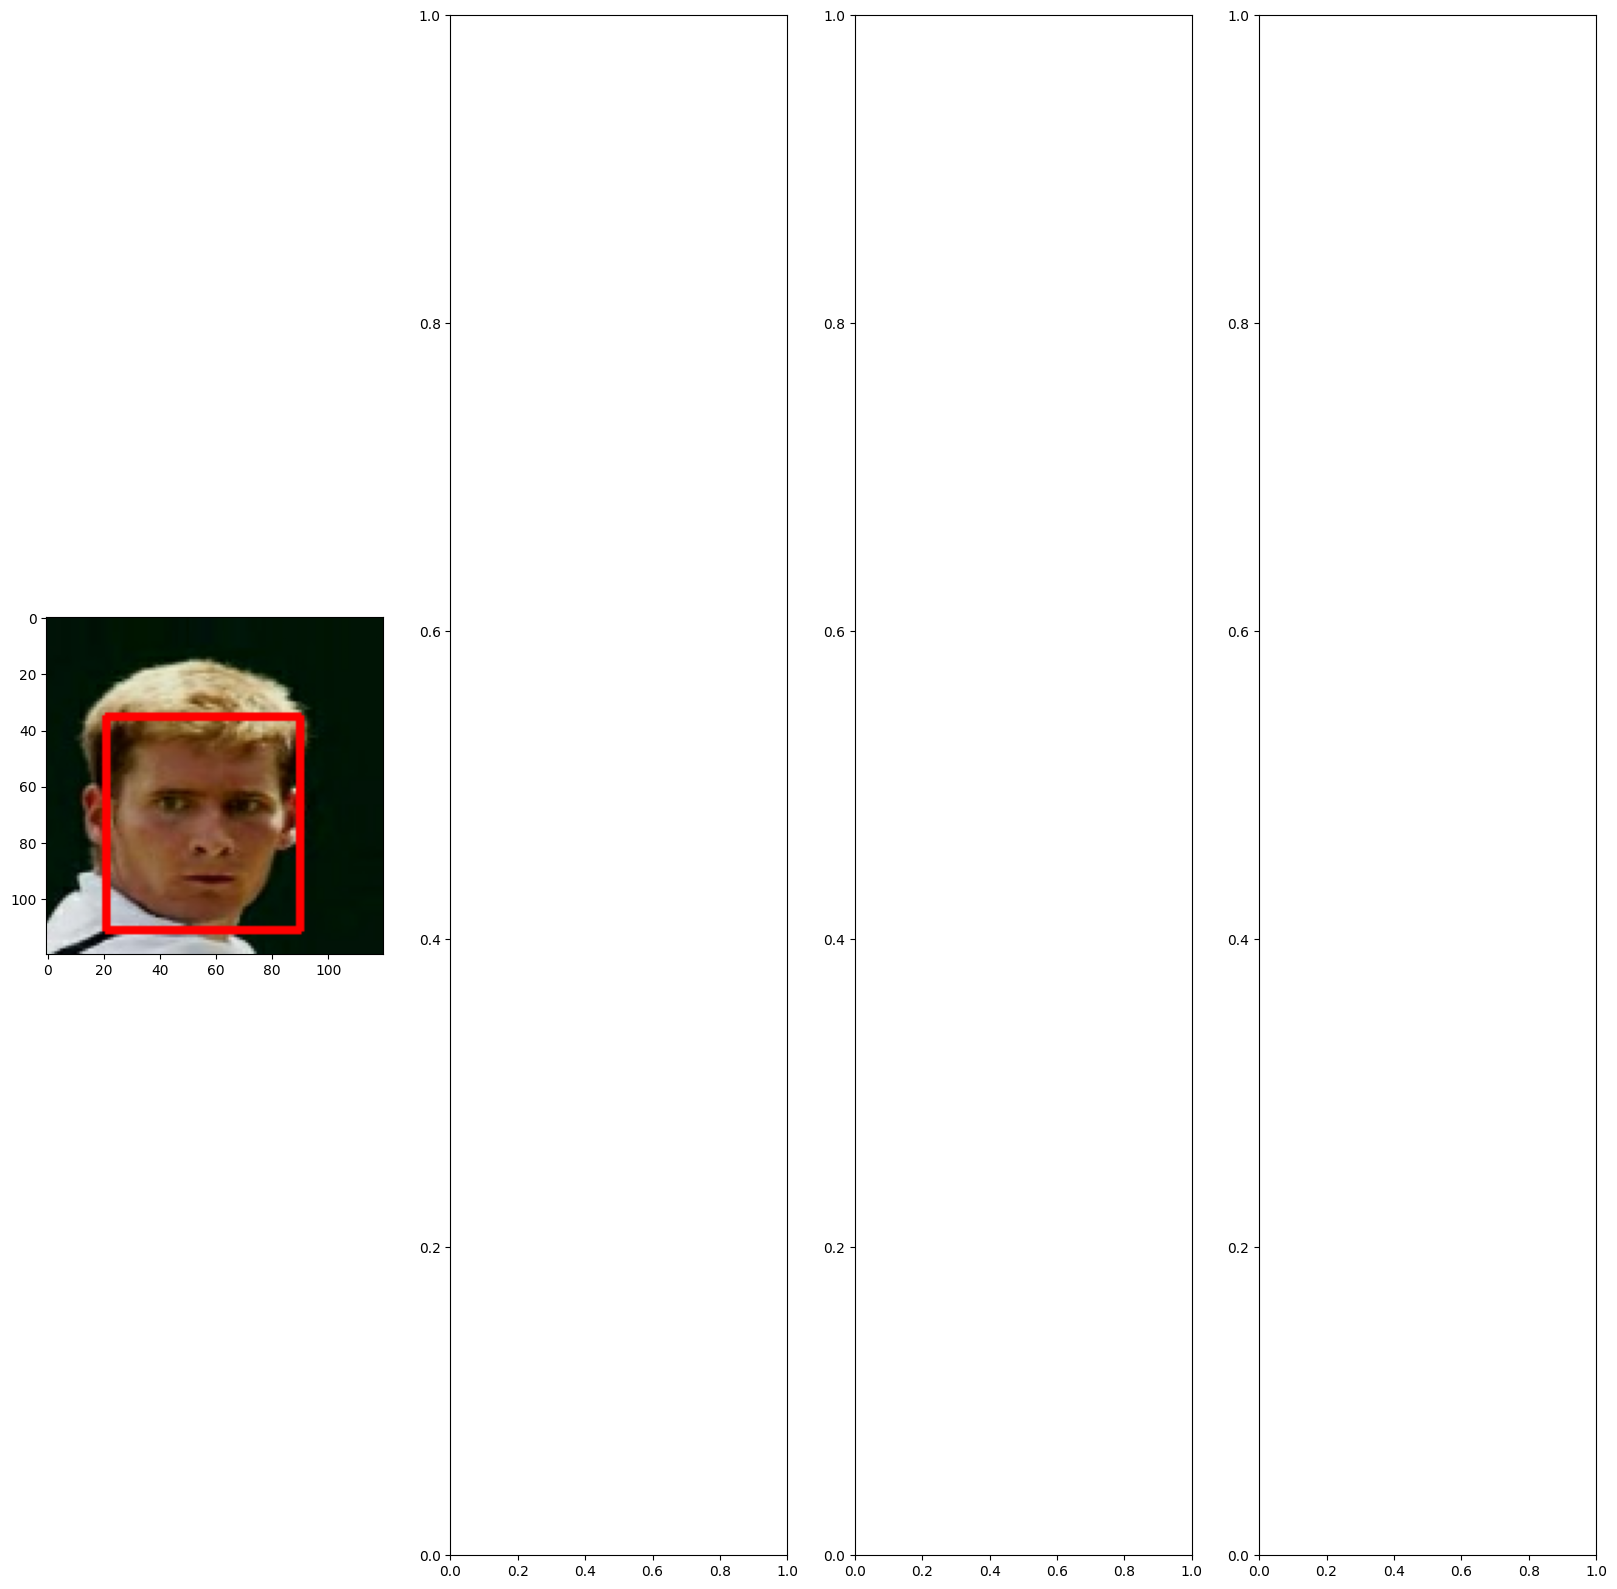

In [79]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(1):
    sample_image = test_sample[0][idx]

    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.9:
        a=tuple(np.multiply(sample_coords[:2], [120,120]).astype(int))
        b=tuple(np.multiply(sample_coords[2:], [120,120]).astype(int))
        print(a,b)
        cv2.rectangle(sample_image,a,b ,
                            (255,0,0), 2)

    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [ ]:
#facetracker.save('facetracker.h5')

### 11.3 Real Time Detection

In [80]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))

    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]

    if yhat[0] > 0.5:
        # Controls the main rectangle
        cv2.rectangle(frame,
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)),
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame,
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])),
                            (255,0,0), -1)

        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

    cv2.imshow('EyeTrack', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()